# Automated real estate evaluator

## Assignment understanding

The real estate market is a complex and dynamic environment; however, property prices are still influenced by a set of objective parameters. Different characteristics of a real estate property have varying impacts on both the quality of life for its inhabitants and the resulting market price. By employing machine learning models, we can identify the respective weight of each parameter, thereby making market navigation and understanding easier for buyers, sellers, and investors.

The goal of this assignment is to develop and evaluate two distinct models:
- A **linear regression model** to predict the continuous *"house price of unit area."*
- A **logistic regression model** to classify whether the house price is above or below the average price within the training data.

By constructing these models, we aim to deepen our understanding of regression logic and further practice the application of the CRISP-DM methodology.

## Data understanding

To build our models, we are using the [Real Estate Valuation Data Set](https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set) from the UCI Machine Learning Repository. This dataset contains 414 instances (*websites*), each described by 6 features (*extracted from the website's URL and source code*) and a House pricing as target variable.

**Target variable** is measured in tens of thousands of Taiwan dollar per Ping and represented as decimal number.

If Y is 10 it will be 10000 TWD = approx to 242 EUR [in 2013](https://twd.fxexchangerate.com/eur-2013_12_27-exchange-rates-history.html), Where [Ping](https://en.wikipedia.org/wiki/Pyeong) is Asian unit of aria equals approx. to 3,3 sqr meter

**Features** represented as numerical values in different units:

| Feature Name                               | Description | Unit |
|--------------------------------------------| --- | --- |
| **X1 transaction date**                    | The date of the transaction (e.g., 2013.250 for March 2013) | Year (fractional) |
| **X2 house age**                           | The age of the house | Years |
| **X3 distance to the nearest MTR station** | The distance to the nearest Mass Rapid Transit station | Meters |
| **X4 number of convenience stores**        | The number of convenience stores within walking distance | Integer |
| **X5 latitude**                            | The geographic coordinate, latitude | Degrees |
| **X6 longitude**                           | The geographic coordinate, longitude | Degrees |


## Data preparation

The process begins with loading the dataset directly from the UCI ML Repository. This is accomplished by using the `ucimlrepo` library, which provides convenient and reproducible access to the data by referencing its unique ID.

In [36]:
# all necessary imports
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report

# Fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

# Data (as pandas dataframes)
X = real_estate_valuation.data.features
y = real_estate_valuation.data.targets

# Combine features and target for easier exploration
df = pd.concat([X, y], axis=1)

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the dataset: ---\n")
display(df.head(5))


# Display the all relevant info
print("\n--- Summary table ---\n")
summary_table = df.describe().T
summary_table['value_type'] = df.dtypes
summary_table['missing'] = df.isnull().sum()
display(summary_table)




--- First 5 rows of the dataset: ---



,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1



--- Summary table ---



,count,mean,std,min,25%,50%,75%,max,value_type,missing_values
X1 transaction date,414.0,2013.148971,0.281967,2012.66700,2012.917000,2013.16700,2013.417000,2013.58300,float64,0
X2 house age,414.0,17.712560,11.392485,0.00000,9.025000,16.10000,28.150000,43.80000,float64,0
X3 distance to the nearest MRT station,414.0,1083.885689,1262.109595,23.38284,289.324800,492.23130,1454.279000,6488.02100,float64,0
X4 number of convenience stores,414.0,4.094203,2.945562,0.00000,1.000000,4.00000,6.000000,10.00000,int64,0
X5 latitude,414.0,24.969030,0.012410,24.93207,24.963000,24.97110,24.977455,25.01459,float64,0
X6 longitude,414.0,121.533361,0.015347,121.47353,121.528085,121.53863,121.543305,121.56627,float64,0
Y house price of unit area,414.0,37.980193,13.606488,7.60000,27.700000,38.45000,46.600000,117.50000,float64,0


From the initial analysis, we can see that data types are appropriate for each column and no missing values were found. Therefore, can safely split the data into two sets and standardize the features.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Useful variable
randomstate = 123

# Do the 70/30 data split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate)

# Do the standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualization
print("\n--- First 5 rows of the scaled training data: ---\n")

# Convert the scaled arrays back to pandas DataFrames for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
display(X_train_scaled.head(5))

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


--- First 5 rows of the scaled training data: ---



,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,0.950982,-0.090643,-0.543453,0.674242,-0.454699,0.613246
1,-1.719796,-1.012062,-0.776334,1.703411,0.374279,0.637070
2,0.356289,-0.116477,-0.211978,-0.011870,0.742082,0.092326
3,-0.829537,0.830776,2.586040,-1.041039,-1.575159,-2.404098
4,-0.829537,-0.383430,-0.463788,0.331186,-0.371071,0.268112


Training set size: 289 samples
Testing set size: 125 samples


## Modeling

choose a machine learning method and train the model (+ model validation)
- which method was used?
- which parameters were used?
- what was the performance of the model?

### Linear regression

In [6]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [7]:
# Kertoimet ja vakiotermi
print(f"Intercept: {linreg.intercept_}")
print("Coefficients:")

# Muutetaan koeffisientit 1D-taulukoksi
coefs = linreg.coef_[0]
features = X.columns

# Käydään nimet ja arvot läpi
for feature, coef in zip(features, coefs): # zip yhdistää kaksi listaa rinnakkain
    print(f"{feature}: {coef:.4f}")


Intercept: [38.20346021]
Coefficients:
X1 transaction date: 1.5032
X2 house age: -3.0049
X3 distance to the nearest MRT station: -6.0670
X4 number of convenience stores: 3.1549
X5 latitude: 2.7356
X6 longitude: -0.4031


In [8]:
# Ennusteita
y_pred = linreg.predict(X_test_scaled)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

Mean Squared Error: 52.324
Mean Absolute Error: 5.346


#### Predicted vs. Actual

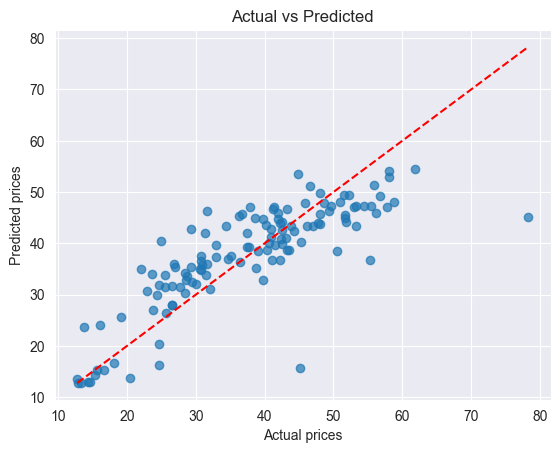

In [10]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonaali
plt.show()


Predictaa hyvin muutamia outliers lukuunottamatta

#### Residual plot

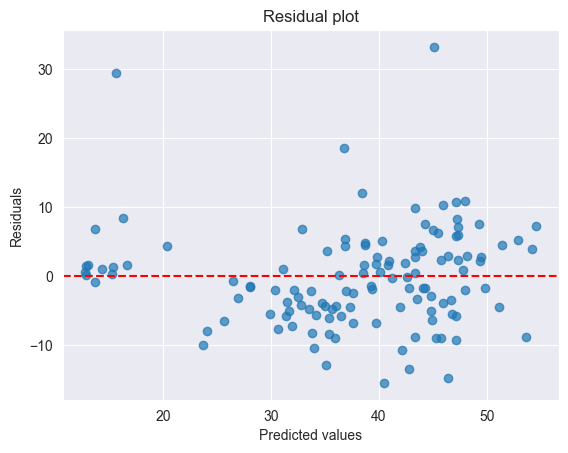

In [11]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual plot")
plt.show()


Hieman heteroscedasticity (hajautuu enemmän mitä oikeammalle mennään)

#### Feature importance

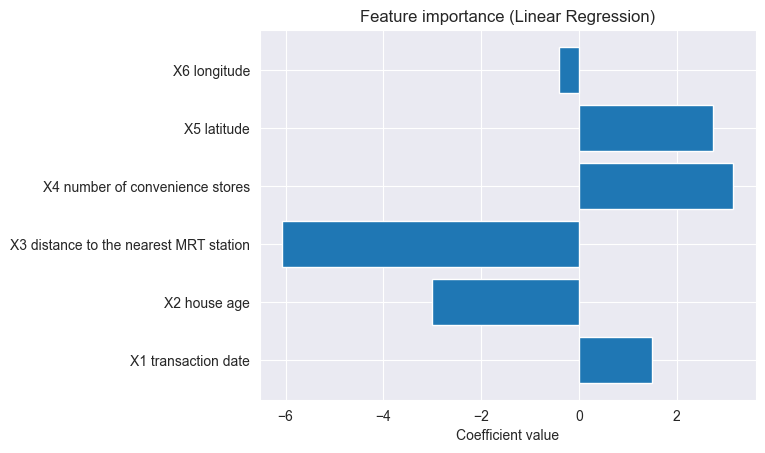

In [12]:
import numpy as np

plt.barh(features, coefs)
plt.xlabel("Coefficient value")
plt.title("Feature importance (Linear Regression)")
plt.show()


Positiivinen nostaa hintaa ja negatiivinen laskee hintaa (esim. mitä enemmän kauppoja, sitä korkeampi hinta tai mitä kauempana metrosta, sitä halvempi)

![Map Image of Xindian District](.\Attachments\img.png)

**If you increase latitude → you go north.**

If you decrease latitude → you go south.

If you increase longitude → you go east.

If you decrease longitude → you go west.

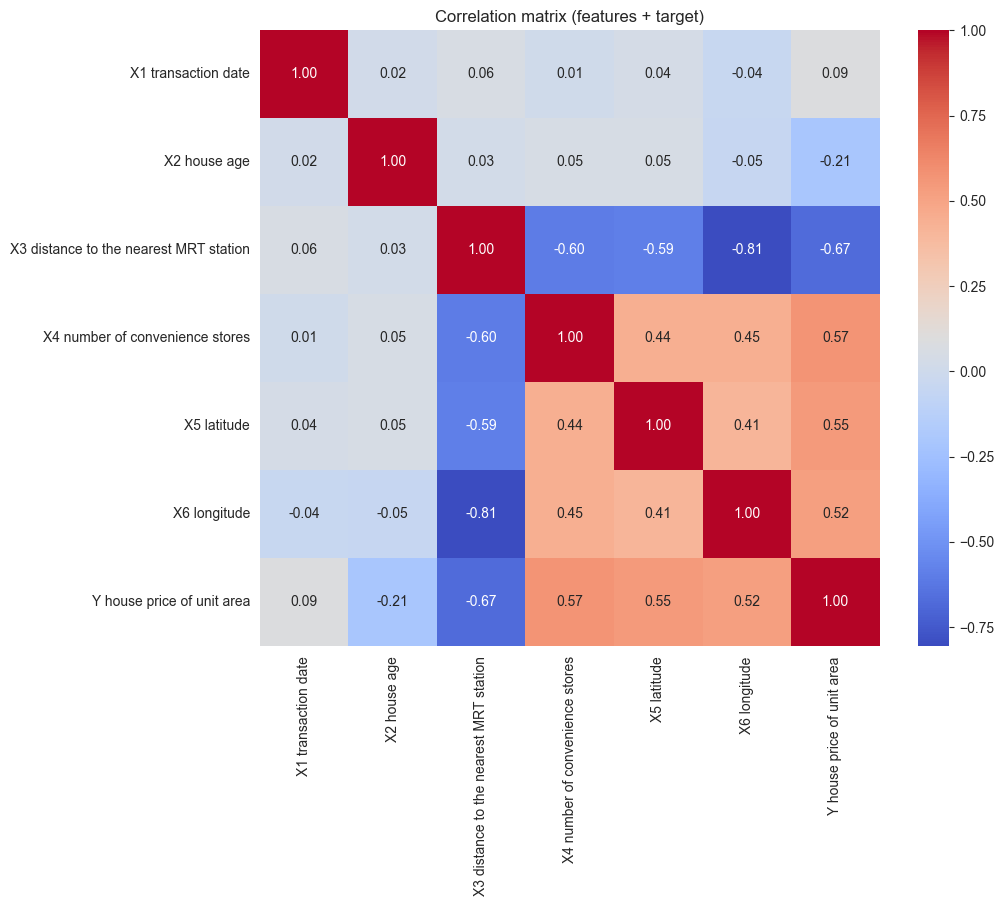

In [13]:
import seaborn as sns
import pandas as pd

# Yhdistetään piirteet ja target yhdeksi DataFrameksi
df_corr = pd.concat([X, y], axis=1)

# Lasketaan korrelaatiomatriisi
corr_matrix = df_corr.corr()

# Piirretään heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
eieplt.show()


### Logistic regression

In [14]:
# get the mean price in the training set
mean_price = y_train.mean()

# convert the target variable into binary
y_train_bin = (y_train > mean_price).astype(int)
y_test_bin  = (y_test > mean_price).astype(int)

In [15]:
from sklearn.linear_model import LogisticRegression

# build and fit model
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_scaled, y_train_bin)

# print coefficients and intercept
print("Intercept: ", logreg.intercept_)
print("Coefficients: ", logreg.coef_)

Intercept:  [-0.79552376]
Coefficients:  [[ 0.32201035 -0.72420697 -2.41508945  0.60045634  0.99249246  0.23871542]]


C:\Users\Pavelishko\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.82
Confusion Matrix:
 [[46 15]
 [ 8 56]]


C:\Users\Pavelishko\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pavelishko\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pavelishko\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pavelishko\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A colu

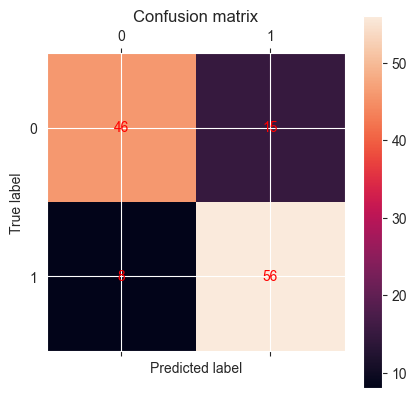

In [16]:
# cross-validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(estimator = logreg, X = X_test_scaled, y = y_test_bin, cv = 10)

cm = confusion_matrix(y_test_bin, y_pred)
accuracy = accuracy_score(y_test_bin, y_pred)

print("Accuracy: %0.2f" % accuracy)
print("Confusion Matrix:\n", cm)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
        
plt.show()

#### Feature importance

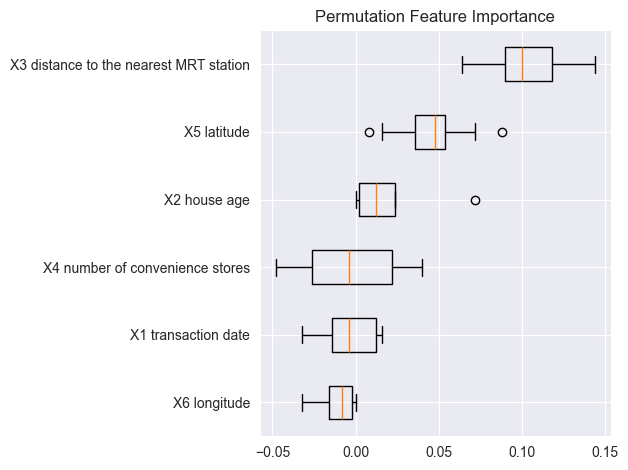

In [17]:
from sklearn.inspection import permutation_importance

result = permutation_importance(logreg, X_test_scaled, y_test_bin, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)

# sort features by importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Feature Importance")
fig.tight_layout()
plt.show()

The plot shows that the higher the value for each feature is, the more important it is. For example, the distance to the nearest metro station would be considered of the highest importance.

#### Interactive prediction

In [18]:
features = X.columns.tolist()  # use your actual feature names

# create empty DataFrame to hold input
Xi = pd.DataFrame(columns=features)

# read input data
for f in features:
    val = input(f"Enter value for feature '{f}': ")
    Xi[f] = [float(val)]

# scale the input
Xi_scaled = pd.DataFrame(scaler.transform(Xi), columns=Xi.columns)

# get probability estimate of class 1 (above-average price)
p = logreg.predict_proba(Xi_scaled)[:, 1]

# output
print("Probability that house price per unit is above average: %0.2f" % p[0])

KeyboardInterrupt: Interrupted by user

## Evaluation

evaluate the model
- How well does the model perform?
- Does it meet the business requirements?

In [ ]:
# hell world

## Deployment

johtopaatos / creating a recommendation of how to use the model in practice, or what to do next
- How will the model be used in practice?
- How will the results be communicated?

In [ ]:
# hello world

### Reflection

#### Ai Usage
- for research

#### Team contribution
- who did what

#### Sources
- links & descriptions